<a href="https://www.kaggle.com/code/tvt2404/dacshutech?scriptVersionId=234235224" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## DDoS Defense: A Multiclass and Multidimensional Detection System with Diverse Machine Learning Models
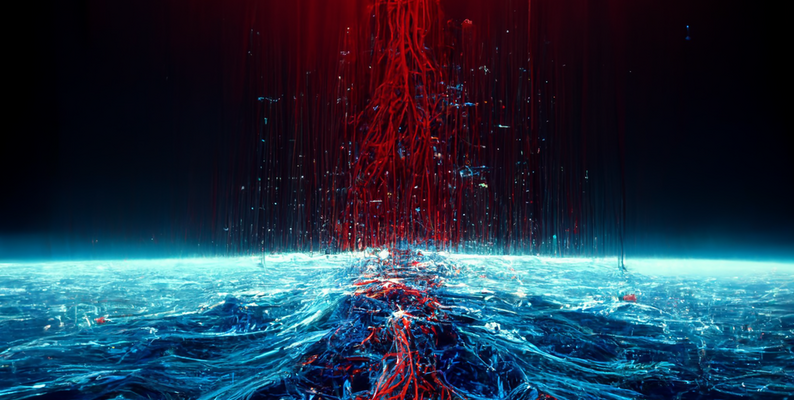
### Project Overview

This project is focused on building a system to detect and classify **DDoS (Distributed Denial of Service)** attacks using the **CICDDoS2019** dataset. The goal is to develop a multiclass classification model that can identify various DDoS attacks from normal network traffic. The dataset consists of multiple attack types with different network traffic characteristics, making it a challenging problem for DDoS detection.

### Dataset Description

The **CICDDoS2019** dataset, provided by the Canadian Institute for Cybersecurity (CIC), contains network traffic data representing several types of DDoS attacks along with benign (non-attack) traffic. The dataset features several attributes like packet size, source/destination IPs, and protocol types. The target variable consists of different attack labels as follows:

- **Syn**: SYN flood attack
- **Benign**: Normal, non-attack traffic
- **Portmap**: Portmapper-based DDoS attack
- **UDP**: Generic UDP flood attack
- **UDPLag**: UDP-based DDoS with lag
- **MSSQL**: MSSQL-specific DDoS attack
- **NetBIOS**: NetBIOS-related DDoS attack
- **LDAP**: Lightweight Directory Access Protocol-based attack

### Process Overview

#### Data Collection and Preprocessing
1. **Collecting Data Paths**:
   - The paths of training and testing datasets are collected using a file walk through. 
   - We ensure that only the datasets with matching names are used for training and testing.

2. **Data Processing**:
   - **Column Mapping**: We map the column names between the training and testing datasets, ensuring they are consistent. The column names in the testing set are renamed to match the training set.
   - **Null and Duplicate Handling**: We check for any null or duplicate values. No null values are found, and any duplicates in the dataset are removed.
   - **Removing Single Unique Value Columns**: Columns with only a single unique value are dropped as they do not provide meaningful information for classification.
   - **Removing Highly Correlated Columns**: Columns with a correlation coefficient of 0.8 or higher are dropped to reduce multicollinearity and improve model performance.

#### Exploratory Data Analysis (EDA)
Several key visualizations were performed to understand the dataset:

- **Distribution of Categorical Columns**: 
   - Frequency distribution using bar plots and percentage distribution using pie charts for categorical features.
- **Flow Duration Distribution**: 
   - Analyzing the flow duration distribution for both DDoS and normal traffic.
- **Packet Length Mean by Protocol and Attack Label**: 
   - Exploring the average packet length by protocol type and attack label.
- **Flags Distribution by Attack Label**: 
   - Distribution of different flag types across attack labels.
- **Protocol Requests Distribution**: 
   - Number of requests coming from different protocols.
- **Correlation Matrix**: 
   - A heatmap to visualize the correlation matrix and identify relationships between features.

#### Data Preprocessing and Feature Engineering
- **Train-Test Split**: 
   - The dataset is split into training, validation, and test sets to ensure proper evaluation of the model.
- **Feature Encoding**: 
   - The target column is encoded using **LabelEncoder** to convert categorical labels into numerical values for training.
- **Feature Scaling**: 
   - We apply **Min-Max Scaling** to scale the features to a uniform range, improving the performance of distance-based algorithms.

#### Model Training and Evaluation
- **Model Selection**: 
   - Several models are trained and evaluated for multiclass classification, including:
     - **Tranfomer**
     - **Convolutional Neural Network (CNN)**
     - **Long Short-Term Memory (LSTM)**
   
- **Model Evaluation**:
   - We evaluate the models using various performance metrics like **accuracy**, **precision**, **recall**, **F1-score**, and **ROC AUC**.
   - ROC curves are plotted to compare the performance of each model across different classes.
   - A table of the model scores is created and displayed for easy comparison.

#### Results Visualization
- **Model Comparison**: 
   - We plot the **accuracy score** for each model to visually compare their performance.
   - ROC curves for all models are plotted to analyze their classification ability, especially for multiclass classification tasks.


## Import Libraries

In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve

# Thêm các thư viện cho CNN, LSTM và Transformer
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, Input, MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Collecting Training and Testing Dataset File Paths
dfps_train = []
dfps_test = []

for dirname, _, filenames in os.walk('/kaggle/input/cicddos2019/'):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_train.append(dfp)
            print(dfp)
        elif filename.endswith('-testing.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_test.append(dfp)
            print(dfp)

In [ ]:
# Common Prefixes in both lists
train_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_train]
test_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_test]

common_prefixes = list(set(train_prefixes).intersection(test_prefixes))

# Filter the dataframes to only include the common prefixes
dfps_train = [dfp for dfp in dfps_train if dfp.split('/')[-1].split('-')[0] in common_prefixes]
dfps_test = [dfp for dfp in dfps_test if dfp.split('/')[-1].split('-')[0] in common_prefixes]

In [ ]:
train_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_train], ignore_index=True)
test_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_test], ignore_index=True)

In [ ]:
print(train_df.shape, test_df.shape)

In [ ]:
train_df.head()

In [ ]:
train_df.info()

In [ ]:
train_df.describe()

## Data Preprocessing

In [ ]:
# Check the target distribution of the training data
print(train_df["Label"].value_counts())

In [ ]:
# Check the target distribution of the testing data
print(test_df["Label"].value_counts())

The `WebDDoS` label is not present in the training data, so we will not be able to use it for training. We will remove it from the testing data.

In [ ]:
# Drop the WebDDoS class from the testing data
test_df = test_df[test_df["Label"] != "WebDDoS"]

The target column values are not matching in the training and testing data. We will replace the target values in the testing data with the values present in the training data.

In [ ]:
# Map the labels to the same format
label_mapping = {
    'DrDoS_UDP': 'UDP',
    'UDP-lag': 'UDPLag',
    'DrDoS_MSSQL': 'MSSQL',
    'DrDoS_LDAP': 'LDAP',
    'DrDoS_NetBIOS': 'NetBIOS',
    'Syn': 'Syn',  # Already matches
    'Benign': 'Benign'  # Already matches
}

test_df["Label"] = test_df["Label"].map(label_mapping)

In [ ]:
# Check the target distribution of the testing data after mapping
print(test_df["Label"].value_counts())

In [ ]:
# Display the columns of the training data
train_df.columns

#### Find the categorical columns, numerical columns, categorical but high cardinality columns.

In [ ]:
def grab_col_names(data, cat_th=10, car_th=20):
    # Categorical columns and categorical but high-cardinality columns
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    num_but_cat = [col for col in data.columns if data[col].nunique() < cat_th and data[col].dtypes != "O"]
    high_card_cat_cols = [col for col in data.columns if data[col].nunique() > car_th and data[col].dtypes == "O"]

    # Combine Object type columns and Low-unique-value numeric columns into cat_cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in high_card_cat_cols]

    # Numerical columns excluding those considered as categorical
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Display information about the dataset
    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f"Categorical Columns: {len(cat_cols)}")
    print(f"Numerical Columns: {len(num_cols)}")
    print(f"High Cardinality Categorical Columns: {len(high_card_cat_cols)}")
    print(f"Number but Categorical Columns: {len(num_but_cat)}")
    print("\n")

    return cat_cols, num_cols, high_card_cat_cols

cat_cols, num_cols, high_card_cat_cols = grab_col_names(train_df)
print(f"Categorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"High Cardinality Categorical Columns: {high_card_cat_cols}")

In [ ]:
# Display the unique values of the categorical columns
for i in cat_cols:
    print(i, train_df[i].unique())

In [ ]:
# Display the columns with only one unique value
for i in train_df.columns:
    if train_df[i].nunique() == 1:
        print(i)

### Missing Values

In [ ]:
# Total number of missing values
print(f"Total number of missing values: {train_df.isnull().sum().sum()}")

### Duplicate Rows

In [ ]:
print(f"Number of Duplicate Rows: {train_df.duplicated().sum()}")

In [ ]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()

# Exploratory Data Analysis (EDA)


### Categorical Columns

In [ ]:
def cat_summary(data, col, plot=False):
    print(pd.DataFrame({col: data[col].value_counts(), "Ratio": data[col].value_counts() / len(data) * 100}))
    print("\n")

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        plt.subplot(1, 2, 1)
        sns.countplot(x=col, data=data)
        plt.xticks(rotation=45)
        plt.title(f"Frequency of {col}")

        plt.subplot(1, 2, 2)
        values = data[col].value_counts()
        plt.pie(x=values, labels=values.index, autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x/100 * sum(values)))
        plt.legend(labels=['{} - {:.2f}%'.format(index, value / sum(values) * 100) for index, value in zip(values.index, values)],
                   loc="upper left",
                   bbox_to_anchor=(1, 1),
                   fancybox=True,
                   shadow=True,
                   ncol=1)
        plt.title(f"Percentage of {col}")
        plt.show(block=True)

for col in cat_cols:
    cat_summary(train_df, col, True)

# Numberical Columns

In [ ]:
# Distribution Plots for Numerical Columns
def my_histplot(data, col, ax):
    sns.histplot(x=col, data=data, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")

def my_distplot(data, col, ax):
    sns.distplot(data[col], ax=ax)
    ax.set_title(f"Distribution of {col}")

def my_kdeplot(data, col, ax):
    sns.kdeplot(x=col, data=data, ax=ax)
    ax.set_title(f"KDE Plot of {col}")

# Relational Plots for Numerical Columns
def my_scatterplot(data, col, ax):
    sns.scatterplot(x=col, data=data, ax=ax)
    ax.set_title(f"Scatter Plot of {col}")

def my_lineplot(data, col, ax):
    sns.lineplot(x=col, data=data, ax=ax)
    ax.set_title(f"Line Plot of {col}")

# Categorical Plots for Categorical Columns
def my_pie_chart(data, col, ax):
    values = data[col].value_counts()
    ax.pie(x=values, labels=values.index, autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x/100 * sum(values)))
    ax.legend(labels=['{} - {:.2f}%'.format(index, value / sum(values) * 100) for index, value in zip(values.index, values)],
              loc="upper left",
              bbox_to_anchor=(1, 1),
              fancybox=True,
              shadow=True,
              ncol=1)
    ax.set_title(f"Pie Chart of {col}")

def my_countplot(data, col, ax):
    sns.countplot(x=col, data=data, ax=ax)
    ax.set_title(f"Count Plot of {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

def my_boxplot(data, col, ax):
    sns.boxplot(y=col, data=data, ax=ax)

def my_violinplot(data, col, ax):
    sns.violinplot(y=col, data=data, ax=ax)

def my_swarmplot(data, col, ax):
    sns.swarmplot(y=col, data=data, ax=ax)

# Matrix Plots for Numerical Columns
def my_headmap(data, size):
    if size: plt.figure(figsize=size)
    sns.heatmap(data.corr(), annot=True, fmt=".1f", cmap="Blues", annot_kws={"size": 12})
    plt.title("Correlation Matrix")
    plt.show()

def plot_charts_grid_single_feature(data, plot_func, size=(12, 4), n_col=1):
    if len(data.columns) == 0:
        return
    n_rows = (len(data.columns) + n_col - 1) // n_col
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(data.columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        plot_func(data, col, axes[i])

    for j in range(i+1, n_rows*n_col):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

In [ ]:
# plot_charts_grid_single_feature(train_df[num_cols], my_histplot, size=(12, 4), n_col=2)

In [ ]:
#plot_charts_grid_single_feature(train_df[num_cols], my_boxplot, size=(2, 4), n_col=6)

### Packet Size and Flow Duration Analysis

In [ ]:
# Boxplot of Flow Duration by Attack Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Flow Duration", data=train_df)
plt.title("Flow Duration Distribution for DDos vs Normal Traffic")
plt.show()

In [ ]:
# Boxplot of Packet Length Mean by Protocol and Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Protocol", y="Packet Length Mean", hue="Label", data=train_df)
plt.title("Packet Length Mean by Protocol and Attack Label")
plt.show()

### Packet Flags and Attack Patterns

In [ ]:
# Counting the number of occurrences of each flag in attack vs normal traffic
flag_cols = [col for col in train_df.columns if "Flag " in col]

for flag in flag_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=flag, hue="Label", data=train_df)
    plt.title(f"{flag} Distribution by Attack Label")
    plt.show()


### Requests from Different Protocols

In [ ]:
# Protocol distribution
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(list(dict(train_df["Protocol"].value_counts()).keys()), dict(train_df["Protocol"].value_counts()).values(), color='r')

plt.xlabel("Protocol")
plt.ylabel("Counts")
plt.legend(["All"])
plt.title("The number of requests from different protocols")
plt.show()

### Correlation Matrix

In [ ]:
# Correlation heatmap
n_numeric_cols = len(train_df.select_dtypes(include=[np.number]).columns)
my_headmap(train_df.select_dtypes(include=[np.number]), size=(n_numeric_cols+1, n_numeric_cols+1))

## Future Engineering

### Feature Selection

In [ ]:
# Features with a single unique value
single_val_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
print("Columns with single value:", single_val_cols)

In [ ]:
# Remove columns with a single unique value
train_df.drop(single_val_cols, axis=1, inplace = True)
test_df.drop(single_val_cols, axis=1, inplace = True)

In [ ]:
# Shape of the dataset after removing columns with a single unique value
print("Dataset shape after removing single value columns:", train_df.shape, test_df.shape)

In [ ]:
# Select only numeric columns
numerical_df = train_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr().abs()

# Generate a boolean mask for the upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(mask)

# Find the columns with correlation of 0.8 or higher
high_corr_cols = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.8)]

# Display the number of highly correlated columns and their names
print(f"Total number of highly correlated columns: {len(high_corr_cols)}")
print("Highly correlated columns are:", high_corr_cols)

In [ ]:
# Remove highly correlated columns from the dataset
train_df.drop(high_corr_cols, axis=1, inplace=True)
test_df.drop(high_corr_cols, axis=1, inplace=True)

In [ ]:
# Shape of the dataset after removing highly correlated columns
print("Dataset shape after removing highly correlated columns:", train_df.shape, test_df.shape)

### Train Test Validation Split

In [ ]:
# Split the data into training, validation, and testing sets
X_train, X_val, y_train, y_val = train_test_split(train_df.drop("Label", axis=1), train_df["Label"], test_size=0.2, random_state=42)
X_test, y_test = test_df.drop("Label", axis=1), test_df["Label"]


In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

In [ ]:
print(y_train.shape, y_val.shape, y_test.shape)


### Feature Encoding

In [ ]:
# Encode the target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Label mapping for the target variable
label_map = {index: Label for index, Label in enumerate(le.classes_)}

In [ ]:
print("Label mapping:", label_map)


### Feature Scaling

In [ ]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



In [ ]:
# Convert target to one-hot encoding for neural networks
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [ ]:
# Reshape data for CNN and LSTM (samples, time steps, features)
# For CNN and LSTM, we need 3D data: [samples, time steps, features]
# Since this is tabular data, we'll use 1 time step
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape),  # kernel_size=1 cho timesteps=1
        Conv1D(filters=128, kernel_size=1, activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(128),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def create_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Add a position embedding
    x = inputs
    
    # Transformer Block
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = LayerNormalization(epsilon=1e-6)(attention_output + x)
    
    # Feed-forward network
    x = Dense(128, activation='relu')(x)
    x = Dense(input_shape[1])(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    
    # Global pooling
    x = GlobalAveragePooling1D()(x)
    
    # Output
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Create and train CNN model
print("\n--- Training CNN Model ---")
cnn_model = create_cnn_model((1, X_train.shape[1]), num_classes)
cnn_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_history = cnn_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val_cat),
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
# Create and train LSTM model
print("\n--- Training LSTM Model ---")
lstm_model = create_lstm_model((1, X_train.shape[1]), num_classes)
lstm_model.summary()

lstm_history = lstm_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val_cat),
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
# Create and train Transformer model
print("\n--- Training Transformer Model ---")
transformer_model = create_transformer_model((1, X_train.shape[1]), num_classes)
transformer_model.summary()

transformer_history = transformer_model.fit(
    X_train_reshaped, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val_cat),
    callbacks=[early_stopping],
    verbose=1
)

In [ ]:
def evaluate_model(model, X_test, y_test, y_test_cat, model_name):
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    roc_auc = roc_auc_score(y_test_cat, y_pred_prob, multi_class="ovr")
    
    # Return metrics as dictionary
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

In [ ]:
# Evaluate all models
scores_list = []
scores_list.append(evaluate_model(cnn_model, X_test_reshaped, y_test, y_test_cat, "CNN"))
scores_list.append(evaluate_model(lstm_model, X_test_reshaped, y_test, y_test_cat, "LSTM"))
scores_list.append(evaluate_model(transformer_model, X_test_reshaped, y_test, y_test_cat, "Transformer"))

# Create DataFrame with scores
scores = pd.DataFrame(scores_list)
print("\nModel Comparison:")
print(scores)

In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Training')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation')
plt.plot(lstm_history.history['accuracy'], label='LSTM Training')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Validation')
plt.plot(transformer_history.history['accuracy'], label='Transformer Training')
plt.plot(transformer_history.history['val_accuracy'], label='Transformer Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Training')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation')
plt.plot(lstm_history.history['loss'], label='LSTM Training')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation')
plt.plot(transformer_history.history['loss'], label='Transformer Training')
plt.plot(transformer_history.history['val_loss'], label='Transformer Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Initialize plot for ROC curves
plt.figure(figsize=(10, 8))

# Generate ROC curves for each model
for model, model_name in zip([cnn_model, lstm_model, transformer_model], ['CNN', 'LSTM', 'Transformer']):
    y_pred_prob = model.predict(X_test_reshaped)
    
    # Plot ROC curve for each class
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
        roc_auc = roc_auc_score(y_test_cat[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'{model_name} - {label_map[i]} (AUC = {roc_auc:.4f})')

# Add random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()

In [ ]:
models = scores['Model']
accuracy = scores['Accuracy']

# Generate a color map
colors = cm.viridis(np.linspace(0, 1, len(models)))

# Plotting the accuracy points with color for each model
plt.figure(figsize=(10, 6))
for i, (model, acc) in enumerate(zip(models, accuracy)):
    plt.plot(model, acc, marker='o', color=colors[i], markersize=8, label=model)

# Adding a line that passes through the points
plt.plot(models, accuracy, linestyle='-', color='#7393B3', linewidth=2, label="Accuracy Line")

# Customizing the plot
plt.title("Accuracy Scores for Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.98, 1) 
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot with legend at the bottom right
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(unique_labels.values(), unique_labels.keys(), loc="lower right")

# Show the plot
plt.tight_layout()
plt.show()

### Export the Best Model (Random Forest) for Deployment


In [ ]:
# Identify the best model based on accuracy
best_model_idx = np.argmax(scores['Accuracy'])
best_model_name = scores.iloc[best_model_idx]['Model']
print(f"\nBest model based on accuracy: {best_model_name}")

# Save the best model
if best_model_name == "CNN":
    best_model = cnn_model
elif best_model_name == "LSTM":
    best_model = lstm_model
else:
    best_model = transformer_model

# Save the model
best_model.save(f'{best_model_name}_ddos_model.h5')
print(f"Best model saved as '{best_model_name}_ddos_model.h5'")

# For compatibility with other systems, also save using pickle
with open(f'{best_model_name}_ddos_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print(f"Model also saved as '{best_model_name}_ddos_model.pkl'")

### Recommendation


### Conclusion

Through this project, I evaluated several machine learning models for DDoS attack detection, aiming to identify the most effective model for classifying various types of DDoS attacks. The results provide insights into the performance of each model, and can help in building more robust cybersecurity systems that are capable of detecting and defending against DDoS attacks in real-world networks.

For more information about the dataset, you can visit the official [CICDDoS2019 Dataset Page](https://www.unb.ca/cic/datasets/ddos-2019.html).